In [1]:
import os
import copy
import warnings
import argparse
import numpy as np

from utils import *
from config import *
from server import *
from model import BiLSTM
from local import LocalUpdate
import torch.utils.tensorboard as tb

warnings.filterwarnings(action='ignore')
parser  = argparse.ArgumentParser(description='Anonymous Federated Learning: Proof of Concept')
parser.add_argument('--testdata', type=str,   default='MNIST')
args    = parser.parse_args(args=[]) # for jupyter ipython
#args    = parser.parse_args(args=[]) # python

In [2]:
DEVICE          = torch.device('cuda:' + str(GPU_NUM) if torch.cuda.is_available() else 'cpu')
DATASET_NAME    = args.testdata
TIME_STEP       = TIME_STEP_MNIST if DATASET_NAME == 'MNIST' else TIME_STEP_CIFAR
INPUT_SIZE      = INPUT_SIZE_MNIST if DATASET_NAME == 'MNIST' else INPUT_SIZE_CIFAR
NUM_OF_CLIENTS  = NUM_OF_CLIENTS_M if DATASET_NAME == 'MNIST' else NUM_OF_CLIENTS_C
SHARDS          = SHARDS * 2       if DATASET_NAME == 'MNIST' else 2

MODEL_NAME      = 'V' + CODE_VERSION + '_' \
                        + FED_MODEL \
                        + '_BiLSTM'    + '_DS-' + DATASET_NAME \
                        + "_B"         + str(BATCH_SIZE) \
                        + "_NOC"       + str(NUM_OF_CLIENTS) \
                        + "_R"         + str(ROUNDS) \
                        + "_L1-"       + str(4) \
                        + "_L2-"       + str(5) \
                        + "_LE"        + str(LOCAL_EPOCH)

DATASET_DIR     += DATASET_NAME
MODEL_SAVE_PATH += MODEL_NAME
TB_DIR          += MODEL_NAME

TB_WRITER       = tb.SummaryWriter(TB_DIR + MODEL_NAME + '/')
MODEL_SAVE_PATH = './saved_model/' + FED_MODEL + '/'
if not os.path.isdir(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

print('--| DEVICE               : ', DEVICE)
print('--| Model name           : ', MODEL_NAME)
print('--| Model save path      : ', MODEL_SAVE_PATH)
print('--| Tensorboard save path: ', TB_DIR)
print('--| Params for training')
print('    Optimizer: {}, Batch size: {}, LR: {}, Bi-LSTM [tstep, input, hidden]: [{}, {}, {}]'.format(
      OPTIMIZER, BATCH_SIZE, LEARNING_RATE, TIME_STEP, INPUT_SIZE, HIDDEN_UNIT))
print('--| Params for fed')
print('    Participant: {}, Num of clients: {}, Local epoch: {}, Round: {}'.format(
      PARTICIPANTS, NUM_OF_CLIENTS * SHARDS, LOCAL_EPOCH, ROUNDS))

--| DEVICE               :  cuda:0
--| Model name           :  V1_AnonymousFed_BiLSTM_DS-MNIST_B32_NOC40_R50_L1-4_L2-5_LE5
--| Model save path      :  ./saved_model/AnonymousFed/
--| Tensorboard save path:  ./tensorboard/V1_AnonymousFed_BiLSTM_DS-MNIST_B32_NOC40_R50_L1-4_L2-5_LE5
--| Params for training
    Optimizer: adam, Batch size: 32, LR: 0.001, Bi-LSTM [tstep, input, hidden]: [28, 28, 64]
--| Params for fed
    Participant: 5, Num of clients: 400, Local epoch: 5, Round: 50


## Main

In [3]:
if __name__ == '__main__':
    train_dataset, test_dataset, user_group = get_dataset_mnist(NUM_OF_CLIENTS, DATASET_DIR, SHARDS) if DATASET_NAME == 'MNIST' else get_dataset_cifar10(NUM_OF_CLIENTS, DATASET_DIR, SHARDS)
    global_model = BiLSTM(TIME_STEP, INPUT_SIZE, HIDDEN_UNIT, BATCH_SIZE, DATASET_NAME)
    global_model.to(DEVICE)
    global_model.train()
    model_size_calculator(global_model)
    
    local_model_list = np.full(NUM_OF_CLIENTS, copy.deepcopy(global_model))
    train_loss, train_acc_test_local, train_acc_test_global, local_train_T = [], [], [], []
    local_FM_list, subglobal_FM_list, global_FM_list = ([[] for _ in range(NUM_OF_CLIENTS)] for _ in range(3))
    
    for round_idx in range(ROUNDS):
        local_weights, local_losses   = [], []
        local_acc_test, local_acc_test_global = [], []
        
        print(f'--| Global Training Round : {round_idx+1} |--')

        global_model.train()
        num_of_participants = PARTICIPANTS 
        idxs_users          = np.random.choice(range(NUM_OF_CLIENTS), num_of_participants, replace=False)

        update_required_user_list = []
        for idx in idxs_users:
            print(f'| Local Training Client : {idx} |')
            update_required_user_list.append(idx)
            local_model = LocalUpdate(train_dataset, test_dataset, user_group[idx], TB_WRITER, LOCAL_BATCH_SIZE, DEVICE)
            
            weight, loss, acc_test, \
            acc_test_global, training_T, \
            local_FM_list[idx], subglobal_FM_list[idx], global_FM_list[idx] = local_model.update_weight(local_model_list[idx], 
                                                                                                        round_idx, 
                                                                                                        OPTIMIZER,
                                                                                                        LEARNING_RATE,
                                                                                                        L2WEIGHT_DECAY, 
                                                                                                        LOCAL_EPOCH, 
                                                                                                        print_log=False)
            
            local_weights.append(copy.deepcopy(weight))
            local_losses.append(loss)
            local_acc_test.append(acc_test)
            local_acc_test_global.append(acc_test_global)
            local_train_T.append(training_T)
                
        grouped_info                         = weight_groupping(idxs_users, local_FM_list, subglobal_FM_list, global_FM_list, PARTICIPANTS)
        updated_local_weights, global_weight = Update_Global_Model(local_weights, grouped_info, idxs_users)
        local_model_list                     = Update_Local_Models(updated_local_weights, update_required_user_list, local_model_list)
        global_model.load_state_dict(global_weight)
        
        local_losses_avg          = np.mean(local_losses)
        local_acc_test_avg        = np.mean(local_acc_test)
        local_acc_test_avg_global = np.mean(local_acc_test_global)
        local_train_T_avg         = np.mean(local_train_T)
        
        train_loss.append(local_losses_avg)
        train_acc_test_local.append(local_acc_test_avg)
        train_acc_test_global.append(local_acc_test_avg_global)
        
        TB_CLI_logger(local_acc_test_avg, local_acc_test_avg_global, local_losses_avg, local_train_T_avg, \
                      PRINT_LOG_INTERVAL, TB_WRITER, MODEL_NAME, round_idx, False)


*** The size of params in the baseline DNN model (i.e., communication cost): 29.450MB
*** The size of params in our modules (i.e., communication cost)           : 0.058MB
*** Communication efficiency 507.83 times better
--| Global Training Round : 1 |--
| Local Training Client : 33 |
| Local Training Client : 23 |
| Local Training Client : 2 |
| Local Training Client : 7 |
| Local Training Client : 20 |

--| Avg Training Stats after  0 global rounds:  |--
Local Training Loss                 : 0.686535
Local Training Accuracy Test        : 89.10%
Local Training Time                 : 1.13239083

--| Global Training Round : 2 |--
| Local Training Client : 7 |
| Local Training Client : 30 |
| Local Training Client : 22 |
| Local Training Client : 37 |
| Local Training Client : 35 |

--| Avg Training Stats after  1 global rounds:  |--
Local Training Loss                 : 0.379150
Local Training Accuracy Test        : 92.64%
Local Training Time                 : 1.12323675

--| Global Tra

| Local Training Client : 16 |
| Local Training Client : 37 |
| Local Training Client : 7 |
| Local Training Client : 25 |

--| Avg Training Stats after  21 global rounds:  |--
Local Training Loss                 : 0.115162
Local Training Accuracy Test        : 97.57%
Local Training Time                 : 1.11596011

--| Global Training Round : 23 |--
| Local Training Client : 3 |
| Local Training Client : 24 |
| Local Training Client : 9 |
| Local Training Client : 34 |
| Local Training Client : 39 |

--| Avg Training Stats after  22 global rounds:  |--
Local Training Loss                 : 0.132383
Local Training Accuracy Test        : 97.43%
Local Training Time                 : 1.11592915

--| Global Training Round : 24 |--
| Local Training Client : 8 |
| Local Training Client : 21 |
| Local Training Client : 24 |
| Local Training Client : 36 |
| Local Training Client : 0 |

--| Avg Training Stats after  23 global rounds:  |--
Local Training Loss                 : 0.106203
Local Tr


--| Avg Training Stats after  42 global rounds:  |--
Local Training Loss                 : 0.090765
Local Training Accuracy Test        : 97.78%
Local Training Time                 : 1.11580564

--| Global Training Round : 44 |--
| Local Training Client : 31 |
| Local Training Client : 9 |
| Local Training Client : 30 |
| Local Training Client : 27 |
| Local Training Client : 28 |

--| Avg Training Stats after  43 global rounds:  |--
Local Training Loss                 : 0.087817
Local Training Accuracy Test        : 98.82%
Local Training Time                 : 1.11594818

--| Global Training Round : 45 |--
| Local Training Client : 34 |
| Local Training Client : 33 |
| Local Training Client : 1 |
| Local Training Client : 17 |
| Local Training Client : 4 |

--| Avg Training Stats after  44 global rounds:  |--
Local Training Loss                 : 0.088646
Local Training Accuracy Test        : 98.54%
Local Training Time                 : 1.11591518

--| Global Training Round : 46 |--


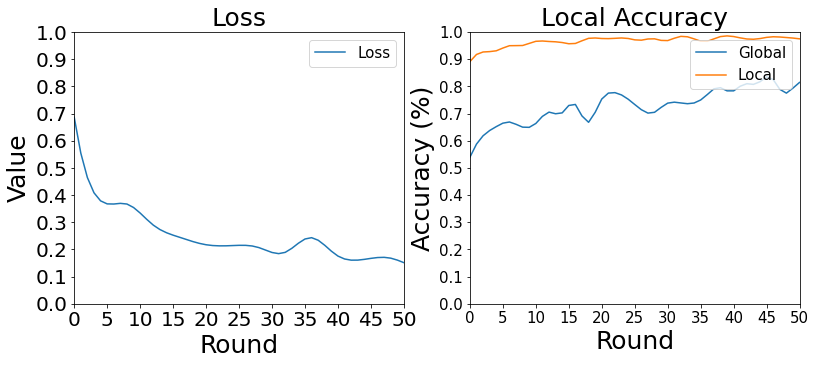

In [5]:
    result_plot(train_loss, train_acc_test_local, train_acc_test_global)